In [1]:
!pip install --upgrade tensorflow==2.12 tensorflow-io==0.32.0 keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 18.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0


## Dataset Overview
Histopathologic cancer detection is a crucial task that involves identifying metastatic cancer in small image patches taken from larger digital pathology scans. The dataset used in this project consists of labeled images, where each label indicates the presence (1) or absence (0) of tumor tissue in the corresponding image. In the experimental, I will use CNN as classifier to identify the tumor tissue.

## Init Environment
First of all, let us import necessary libraries and connect accelerators such as TPUs or GPUs.

In [2]:
import numpy as np # linear algebra
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

## EDA
I read the dataset by pandas and view it heads, as you can see, there are two columns, id and label.

In [3]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


I get classes from label column. According to result, it's a binary classification problem.

In [4]:
df['label'].unique()

array([0, 1])

I separate csv dataset to train csv dataset and validate csv dataset. 

In [5]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_df.to_csv('./train.csv')
val_df.to_csv('./val.csv')

There are 176020 samples in trian dataset and 44005 samples in validate dataset.

In [6]:
train_df.info()
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176020 entries, 64591 to 49244
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      176020 non-null  object
 1   label   176020 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44005 entries, 46061 to 217424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      44005 non-null  object
 1   label   44005 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In order to speed up dataset processing, I use Tensorflow Dataset as dataset processor, which could accelerate data processing via multi threads on CPUs.

In [7]:
train_dataset = tf.data.experimental.make_csv_dataset(
      './train.csv',
      batch_size=64,
      label_name='label',
      num_epochs=None,
      num_parallel_reads=8,
      shuffle=True,
      sloppy=True,
      ignore_errors=True).cache()

val_dataset = tf.data.experimental.make_csv_dataset(
      './val.csv',
      batch_size=128,
      label_name='label',
      num_epochs=1,
      num_parallel_reads=8,
      shuffle=False,
      sloppy=True,
      ignore_errors=True).cache()

I decode the tiff images and convert images to floats between 0 and 1.

In [8]:
def decode_tiff(x, y):
    def decode(id):
        path = '/kaggle/input/histopathologic-cancer-detection/train/'+id+'.tif'
        content = tf.io.read_file(path)
        image = tfio.experimental.image.decode_tiff(content)
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = tf.image.resize(image, [96, 96])
        image.set_shape([96, 96 ,4])
        return image
    
    tiffs = tf.vectorized_map(decode, x['id'])
    return tiffs, y

train_dataset = train_dataset.map(decode_tiff, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(decode_tiff, num_parallel_calls=tf.data.AUTOTUNE)

I plot the processed images. The cells in the images with tumor tissues are sparse than absence ones. It's a major feature to classify images.

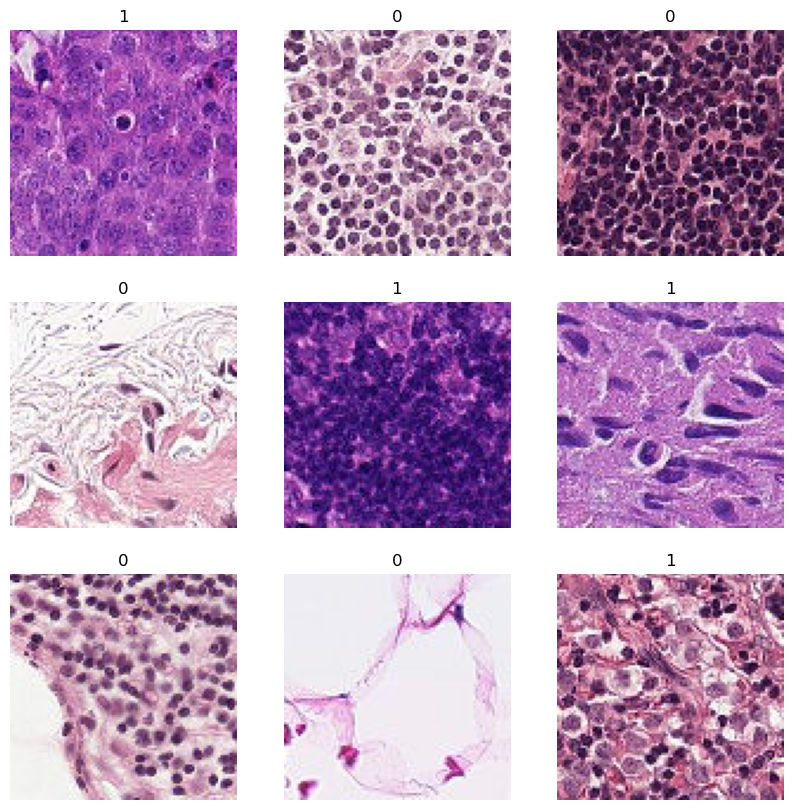

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
    images = images.numpy()
    labels = labels.numpy()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("float32"))
        plt.title(labels[i])
        plt.axis("off")

After review images, I found colors isn't important for classifying images, so I convert images to grayscale format in order to remove color feature, the process could also reduce model parameters. I also employ random flip as an data augment method.

In [10]:
def augment(x, y):
    x = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x[..., :3])),
    ])(x)
    return x, y
augmented_train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x[..., :3]), y), num_parallel_calls=tf.data.AUTOTUNE)

Plot grayscale images.

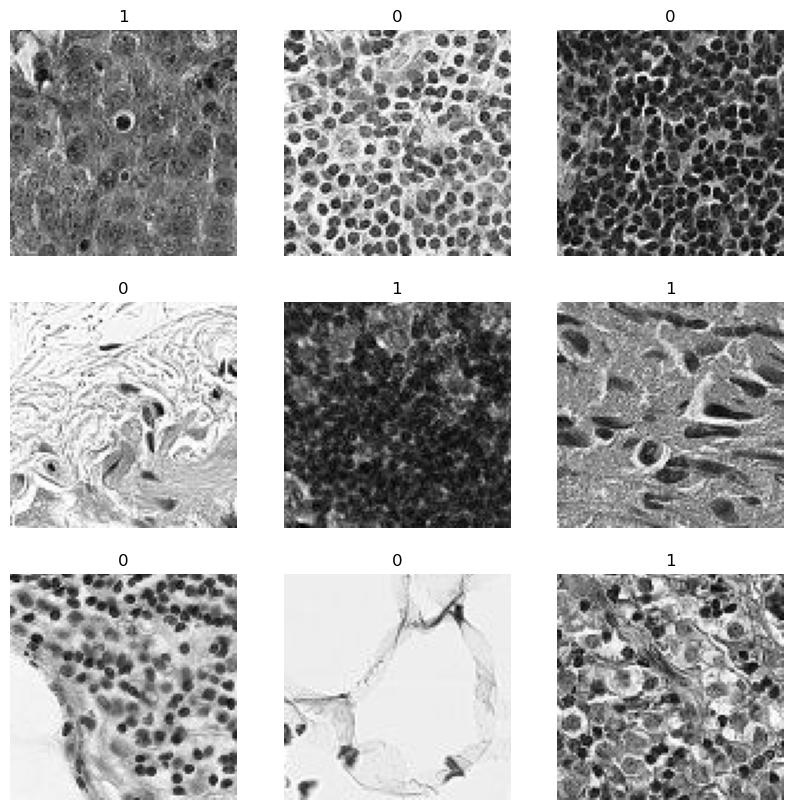

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
    images = images.numpy()
    labels = labels.numpy()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("float32"), cmap='gray')
        plt.title(labels[i])
        plt.axis("off")

## Build Model
I want to normalize inputs into a distribution centered around 0 with standard deviation 1. Thanks to keras Normalization layer, I could easily use it by adapt the dataset with a number of samples, then call the layer directly.

In [13]:
with strategy.scope():
    norm = tf.keras.layers.Normalization()
    norm.adapt(augmented_train_dataset.map(lambda x,y: x, num_parallel_calls=tf.data.AUTOTUNE), steps=1000)

I use conv-bn-relu as basic block to build the demo model, the GlobalMaxPooling layer get max value of each filter, then the model uses MLP to predict classes from previous outputs.

In [14]:
def build_model(kernel_size, label_smoothing, padding, momentum, activation, dropout_rate, optimizer, layers):
    inputs = tf.keras.layers.Input([96, 96, 1])
    x = norm(inputs, training=False)
    for i in range(layers):
        x = tf.keras.layers.Conv2D(32*(2**i), kernel_size, padding=padding)(x)
        x = tf.keras.layers.BatchNormalization(momentum=momentum)(x)
        x = tf.keras.layers.Activation(activation)(x)
    pooling = tf.keras.layers.GlobalMaxPooling2D()(x)
    dense1 = tf.keras.layers.Dense(32*(2**layers), activation=activation)(pooling)
    dropout1 = tf.keras.layers.Dropout(dropout_rate)(dense1)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dropout1)
    model = tf.keras.Model(inputs, outputs)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

with strategy.scope():
    model = build_model(3, 0, 'same', 0.99, 'relu', 0.25, 'adam', 4)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 normalization_1 (Normalizat  (None, 96, 96, 1)        3         
 ion)                                                            
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496 

I train the model 10 epochs with 100 steps then I plot the training history, according to the plot, the model arch works on the dataset.

In [ ]:
history = model.fit(augmented_train_dataset, validation_data=val_dataset, epochs=10, steps_per_epoch=100, validation_steps=20)
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC')
plt.plot(epochs_range, val_acc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Tune Model
In the section, I employ Hyperband as hyper parameters tuner. Hyperband is a Bayesian approach to hyperparameter optimization (HPO) that uses an iterative halving algorithm to explore a large space of hyperparameters efficiently. It is a bandit-based algorithm, which means that it makes decisions about which hyperparameter configurations to evaluate based on the results of previous evaluations. Hyperband works by first dividing the budget (the total amount of time or resources that can be used for HPO) into a number of stages. Each stage has a smaller budget than the previous stage, so fewer hyperparameter configurations can be evaluated in each stage. The number of stages is determined by a parameter called eta, which controls the exploration vs. exploitation trade-off. With the approach, we could tune the model in a relative short time. I add some canadidates to the tuner such as optimizer, activation. dropout rate, etc. They are printed by ```search_space_summary```.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True)

def build_tuner(hp):
    optimizer=hp.Choice('optimizer', ['rmsprop', 'adam'])
    label_smoothing = hp.Choice('label_smothing', [0.0, 0.01])
    kernel_size = hp.Choice('kernel_size', [3, 5])
    padding = hp.Choice('padding', ['same', 'valid'])
    momentum = hp.Choice('momentum', [0.9, 0.99, 0.999])
    activation = hp.Choice('acitvation', ['relu', 'swish'])
    layers = hp.Int('layers', min_value=3, max_value=5)
    dropout_rate = hp.Choice('dropout_rate', [0., 0.25, 0.5])
    return build_model(kernel_size, label_smoothing, padding, momentum, activation, dropout_rate, optimizer, layers)

tuner = kt.Hyperband(
    build_tuner,
    max_epochs=200,
    distribution_strategy=strategy,
    project_name='HistoPathologicCancerDetection',
    objective=kt.Objective("val_auc", direction="max"))
tuner.search_space_summary(extended=False)
tuner.search(augmented_train_dataset, validation_data=val_dataset, epochs=10, steps_per_epoch=400, validation_steps=100, callbacks=[early_stopping])

## Submit Results
Before submit the results, let's make test dataset and use top 3 trained model to predict results, then store the results in ```csv``` files(Without separate train and validate dataset).

In [16]:
from tqdm import tqdm
test_dataset = tf.data.Dataset.list_files("/kaggle/input/histopathologic-cancer-detection/test/*.tif")

def preprocess(path):
    slices = tf.strings.split(path, '/')
    id = tf.strings.split(slices[-1], '.')[0]
    content = tf.io.read_file(path)
    image = tfio.experimental.image.decode_tiff(content)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, [96, 96])
    return id, tf.image.rgb_to_grayscale(image[..., :3])

test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(128)

tuner.results_summary(num_trials=3)
models = tuner.get_best_models(num_models=3)

count = test_dataset.cardinality().numpy()
for i, model in enumerate(models):
    id = []
    label = []
    for ids, images in tqdm(test_dataset, total=count):
        preds = model(images)
        id += [item.decode('utf-8') for item in ids.numpy().tolist()]
        label += tf.squeeze(preds).numpy().tolist()
    
    data = {'id': id,
            'label': label}

    test_df = pd.DataFrame(data)
    test_df.to_csv(f'./submission_{i}.csv', index=False)

Results summary
Results in ./HistoPathologicCancerDetection
Showing 3 best trials
Objective(name="val_auc", direction="max")

Trial 0147 summary
Hyperparameters:
optimizer: adam
label_smothing: 0.0
kernel_size: 5
padding: same
momentum: 0.9
acitvation: relu
layers: 4
dropout_rate: 0.25
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.9770394563674927

Trial 0144 summary
Hyperparameters:
optimizer: adam
label_smothing: 0.01
kernel_size: 5
padding: same
momentum: 0.9
acitvation: relu
layers: 4
dropout_rate: 0.0
tuner/epochs: 67
tuner/initial_epoch: 23
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0138
Score: 0.9751632809638977

Trial 0146 summary
Hyperparameters:
optimizer: adam
label_smothing: 0.01
kernel_size: 5
padding: same
momentum: 0.9
acitvation: relu
layers: 4
dropout_rate: 0.0
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Score: 0.9750880599021912


100%|██████████| 449/449 [01:21<00:00,  5.48it/s]


## Conclusion
Although I have trained a model could detect the tumor tissue, these still are some aspects are worth to explore.

1. Focal loss addresses this problem by assigning a higher weight to hard misclassified samples. Hard misclassified samples are those that the model is confident about but still gets wrong. It could improve model performance on hard samples。
2. PCA is often used for dimensionality reduction, which is the process of reducing the number of variables in a dataset while preserving as much information as possible. According to the samples, there are lots of useless information in the picture, so we could use PCA to remove these features.

According to tuner summary, there are also some hyperparameters are not worth to tune. Such as optimizer, mnomentum and padding, they have a single value which is always better than others.